In [1]:
import geopandas

gdf = geopandas.read_file("tmp/n761s-acceleration.gpx", layer='track_points')
gdf.head()

,track_fid,track_seg_id,track_seg_point_id,ele,time,magvar,geoidheight,name,cmt,desc,...,sym,type,fix,sat,hdop,vdop,pdop,ageofdgpsdata,dgpsid,geometry
0,0,0,0,0.000,2022-12-07 19:05:55.708000+00:00,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-122.11216 37.45716)
1,0,0,1,0.000,2022-12-07 19:05:56.617000+00:00,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-122.11216 37.45716)
2,0,0,2,-1.524,2022-12-07 19:05:57.621000+00:00,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-122.11216 37.45716)
3,0,0,3,0.000,2022-12-07 19:05:58.691000+00:00,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-122.11216 37.45716)
4,0,0,4,0.000,2022-12-07 19:05:59.674000+00:00,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-122.11216 37.45716)


In [2]:
import lowry
Q_ = lowry.ureg.Quantity
gdf['ele_ft'] = gdf.ele.transform(lambda x: Q_(x, 'meter').m_as('ft'))

In [3]:
# run 1
runs = [
 {"times": ["2022-12-07T19:21:50Z", "2022-12-07T19:22:32Z"]},
 {"times": ["2022-12-07T19:25:22Z", "2022-12-07T19:26:06Z"]},
 {"times": ["2022-12-07T19:31:32Z", "2022-12-07T19:32:15Z"]},
 {"times": ["2022-12-07T19:34:48Z", "2022-12-07T19:35:30Z"]}]

runs = [gdf[(gdf['time'] >= run['times'][0]) & (gdf['time'] <= run['times'][1])] for run in runs]

(4200.0, 5400.0)

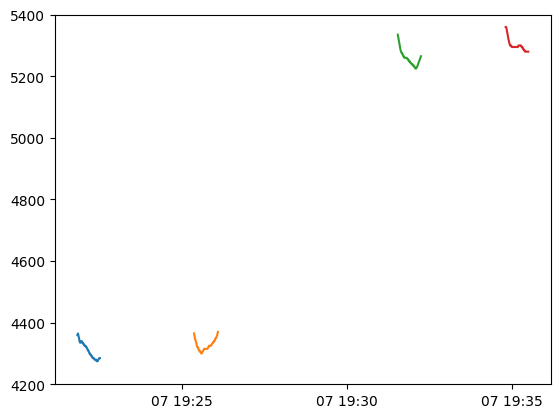

In [4]:

%matplotlib inline
import matplotlib.pyplot as plt, mpld3

# they look flat-ish? they're +/- 50 so probably ok but I think the area of interest is right near the beginning where things are changing the most (diving a bit)
# I wonder if I could use a much lower power setting and still get Vx - things would move slower.
fig, ax = plt.subplots()
for run in runs:
    ax.plot(run.time, run.ele_ft)
ax.set_ylim([4200,5400])